Train: 15379, Validation: 3845, Test: 3196
224 Hello bro imageSize
Sequential model built successfully.
Epoch 1/5
1537/1537 [==============================] - 258s 166ms/step - loss: 0.3393 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.1528 - val_sparse_categorical_accuracy: 0.9482
Epoch 2/5
1537/1537 [==============================] - 142s 91ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.1225 - val_sparse_categorical_accuracy: 0.9573
Epoch 3/5
1537/1537 [==============================] - 142s 93ms/step - loss: 0.0976 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.1046 - val_sparse_categorical_accuracy: 0.9651
Epoch 4/5
1537/1537 [==============================] - 140s 91ms/step - loss: 0.0802 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.1097 - val_sparse_categorical_accuracy: 0.9664
Epoch 5/5
1537/1537 [==============================] - 142s 93ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0922 - val_sparse_cate

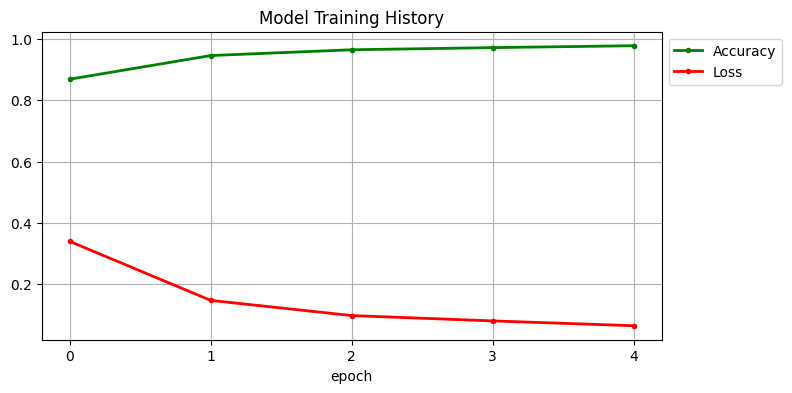

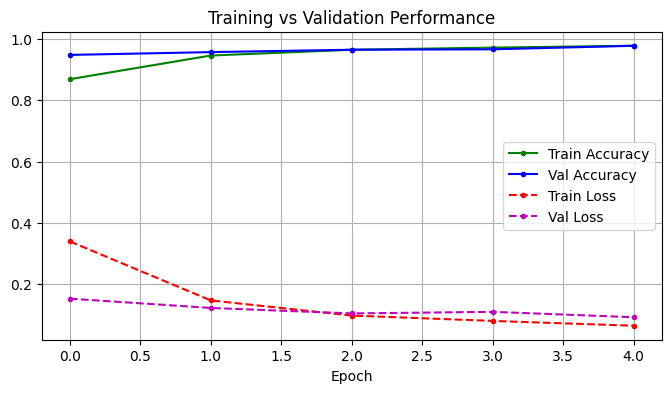

1/1 [==============================] - 1s 727ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       599
           1       0.97      0.94      0.95       619
           2       1.00      1.00      1.00      1079
           3       0.98      1.00      0.99       899

    accuracy                           0.98      3196
   macro avg       0.98      0.98      0.98      3196
weighted avg       0.98      0.98      0.98      3196

Confusion Matrix:
[[ 579   20    0    0]
 [  14  583    3   19]
 [   2    1 1076    0]
 [   1    0    0  898]]


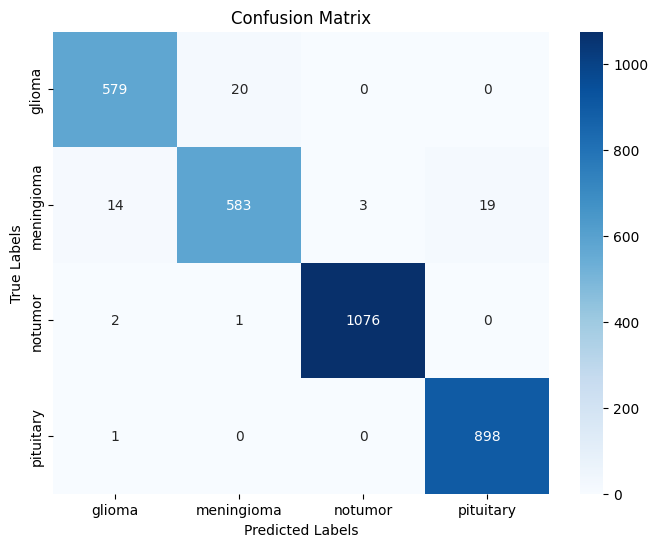

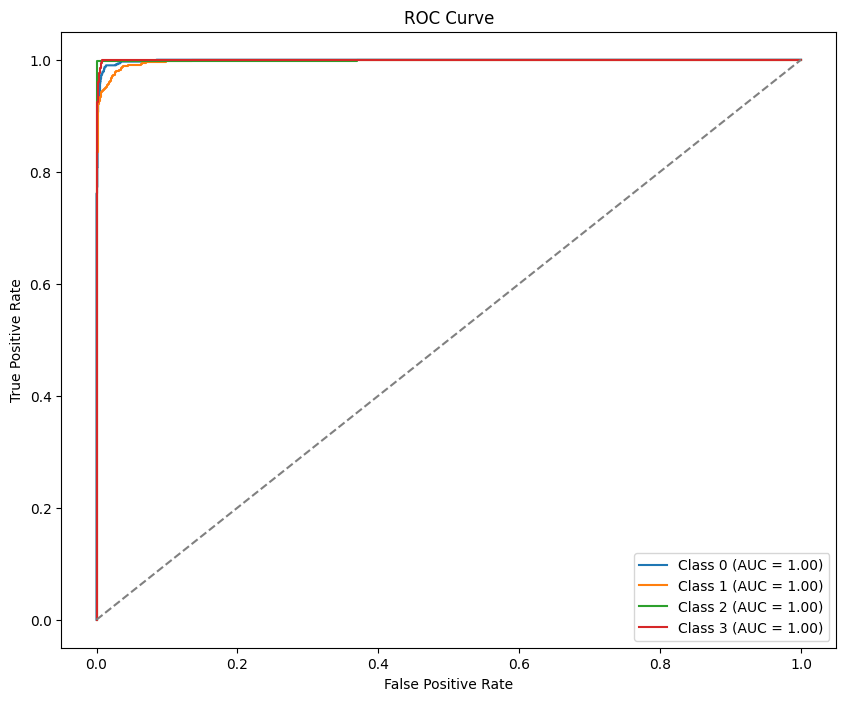

In [2]:
import os
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import base64


# -----------------------------
# Paths and constants
# -----------------------------
train_dir = '../brain_tumor_images/Training'
test_dir = '../brain_tumor_images/Testing'
IMAGE_SIZE = 224
BATCH_SIZE = 10
EPOCHS = 5

brain_tumor_labels = os.listdir(train_dir)
num_classes = len(brain_tumor_labels)

# -----------------------------
# Data Loading
# -----------------------------
def load_data(directory):
    paths, labels = [], []
    for label in os.listdir(directory):
        for img in os.listdir(os.path.join(directory, label)):
            paths.append(os.path.join(directory, label, img))
            labels.append(label)
    return shuffle(paths, labels)

train_paths, train_labels = load_data(train_dir)
test_paths, test_labels = load_data(test_dir)

# Train-validation split
val_split = int(0.8 * len(train_paths))
val_paths, val_labels = train_paths[val_split:], train_labels[val_split:]
train_paths, train_labels = train_paths[:val_split], train_labels[:val_split]

print(f"Train: {len(train_paths)}, Validation: {len(val_paths)}, Test: {len(test_paths)}")

# -----------------------------
# Image Augmentation
# -----------------------------
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image)/255.0

def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = augment_image(np.array(img))
        images.append(img)
    return np.array(images)

def encode_label(labels):
    return np.array([brain_tumor_labels.index(label) for label in labels])

def datagen(paths, labels, batch_size=BATCH_SIZE):
    while True:
        paths, labels = shuffle(paths, labels)
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = encode_label(labels[i:i+batch_size])
            yield batch_images, batch_labels

# -----------------------------
# Sequential Model with VGG16
# -----------------------------
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE
epochs = 5
print(IMAGE_SIZE,'Hello bro imageSize')
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Force build
model(np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 3)))
print("Sequential model built successfully.")

# -----------------------------
# Train the model
# -----------------------------
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE

history = model.fit(
    datagen(train_paths, train_labels),
    steps_per_epoch=steps_per_epoch,
    validation_data=datagen(val_paths, val_labels),
    validation_steps=validation_steps,
    epochs=EPOCHS
)
# -----------------------------
# Plot training history
# -----------------------------
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '.b-', label='Val Accuracy')
plt.plot(history.history['loss'], '.r--', label='Train Loss')
plt.plot(history.history['val_loss'], '.m--', label='Val Loss')
plt.title('Training vs Validation Performance')
plt.xlabel('Epoch')
plt.legend()
plt.show()







# Parameters
batch_size = 8  # adjust if still memory issue
num_classes = len(os.listdir(train_dir))

# 1. Prediction on test data in batches
test_labels_encoded = encode_label(test_labels)  # Encode the test labels
y_pred_probs = []

for i in range(0, len(test_paths), batch_size):
    batch_paths = test_paths[i:i + batch_size]
    batch_images = open_images(batch_paths)  # Load and augment batch
    batch_pred = model.predict(batch_images)
    y_pred_probs.extend(batch_pred)

y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, y_pred_classes))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=os.listdir(train_dir), 
            yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(num_classes))
test_predictions_bin = y_pred_probs  # predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [3]:
model.save('vgg224_newone.h5')  


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 10,291,332
No

In [1]:
import os
import numpy as np
from PIL import Image
import imghdr
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ------------------------------
# Step 1: Technical Image Validation
# ------------------------------
def validate_image(file_path):
    if not os.path.exists(file_path):
        return False, "File not found"

    if imghdr.what(file_path) not in ['jpeg', 'png', 'jpg']:
        return False, "Invalid image type"

    try:
        img = Image.open(file_path)
        img.verify()  # check corruption
        img = Image.open(file_path)
        if img.size[0] < 50 or img.size[1] < 50:  # smaller because we resize to 128
            return False, "Image too small"
    except Exception as e:
        return False, str(e)
    
    return True, "Valid image"

# ------------------------------
# Step 2: Brain MRI Validator Model (Transfer Learning)
# ------------------------------
def build_brain_mri_validator(input_shape=(128,128,3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)  # hidden layer
    output = Dense(1, activation='sigmoid')(x)  # MRI / Not MRI

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ------------------------------
# Step 3: Load & Preprocess Image
# ------------------------------
def load_and_preprocess_image(file_path, target_size=(128,128)):
    img = Image.open(file_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# ------------------------------
# Step 4: Load Validator Model
# ------------------------------
validator_model = build_brain_mri_validator()
validator_model.load_weights('new_final_year_model.h5')  # trained weights

def is_brain_mri(file_path, threshold=0.8):
    img_array = load_and_preprocess_image(file_path)
    pred = validator_model.predict(img_array)[0][0]
    return pred >= threshold, pred

# ------------------------------
# Step 5: Example Usage
# ------------------------------
file_path = 'test_image.jpg'

# Step 5a: Technical validation
valid, msg = validate_image(file_path)
if not valid:
    print(f"Rejected: {msg}")
else:
    # Step 5b: Brain MRI validation
    brain_mri, confidence = is_brain_mri(file_path)
    if brain_mri:
        print(f"Accepted: Brain MRI detected with confidence {confidence:.2f}")
        # Pass file_path to your brain tumor model here
    else:
        print(f"Rejected: Not a brain MRI. Confidence {confidence:.2f}")


ValueError: Layer count mismatch when loading weights from file. Model expected 133 layers, found 3 saved layers.